# Section D. Ridge Regression

In this section, you develop Ridge Regression by adding the L2 norm regularization to the linear regression (covered in Activity 1 of Module 2) and study the effect of the L2 norm regularization on the training and testing errors. This section assesses your mathematical skills (derivation), programming, and analytical skills.


####  Question 5 [Ridge Regression, 25 Marks]

I. Given the gradient descent algorithms for linear regression (discussed in Chapter 2 of Module 2), derive weight update steps of stochastic gradient descent (SGD) for linear regression with L2 regularisation norm. Show your work with enough explanation in your PDF report; you should provide the steps of SGD.

Hint: Recall that for linear regression we defined the error function E. For this assignment, you only need to add an L2 regularization term to the error function (error term plus the regularization term). This question is similar to Activity 1 of Module 2.

    II. Using R (with no use of special libraries), implement an SGD algorithm that you derived in Step I. The implementation is straightforward as you are allowed to use the code examples provided.
    
#### Importing Libraries

In [9]:
library(ggplot2)
library(reshape2)

#### Provided Functions

In [10]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
   return(errors)
}

In [11]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = - c(y_true-y_pred) * x + lambda * W_prev
   return(W_prev - eta * grad)
}

    III. Now let’s study the effect of the L2 norm regularization on the training and testing errors:

        a. Load Task1C_train.csv and Task1C_test.csv sets.

In [12]:
train <- read_data("data/Sintetic1C_train.csv", TRUE)
test <- read_data("data/Sintetic1C_test.csv", TRUE)

    b. For each lambda in {0, 0.4, 0.8, …, 10}, build a regression model and compute the training and testing errors, using the provided data sets. While building each model, all parameter settings (initial values, learning rate, etc) are exactly the same, except a lambda value. Set the termination criterion as maximum of 20 x N weight updates (where N is the number of training data). Create a plot of error rates (use different colors for the training and testing errors), where the x-axis is log lambda and y-axis is the error rate. Save your plot in your Jupyter Notebook file for Question 5.


In [13]:
set.seed(1234)

error_matrix = matrix(, nrow= 41 , ncol=3, dimnames = list(c(),c("L", "train", "test")))

i = 1
for (l in seq(0, 10, by = 0.4)){

    train_res = sgd_train(train$x, train$y, l, eta = .05, epsilon = .001, max_epoch = 20)
    e = get_errors(train, test, train_res$W)
    
    #saving the minimum
    error_matrix[i,] <- c(l, e[nrow(e),])
    
    i = i + 1
}

error.m <- melt(id.vars = "L" , data = as.data.frame(error_matrix))


Warning message:
"Removed 30 row(s) containing missing values (geom_path)."


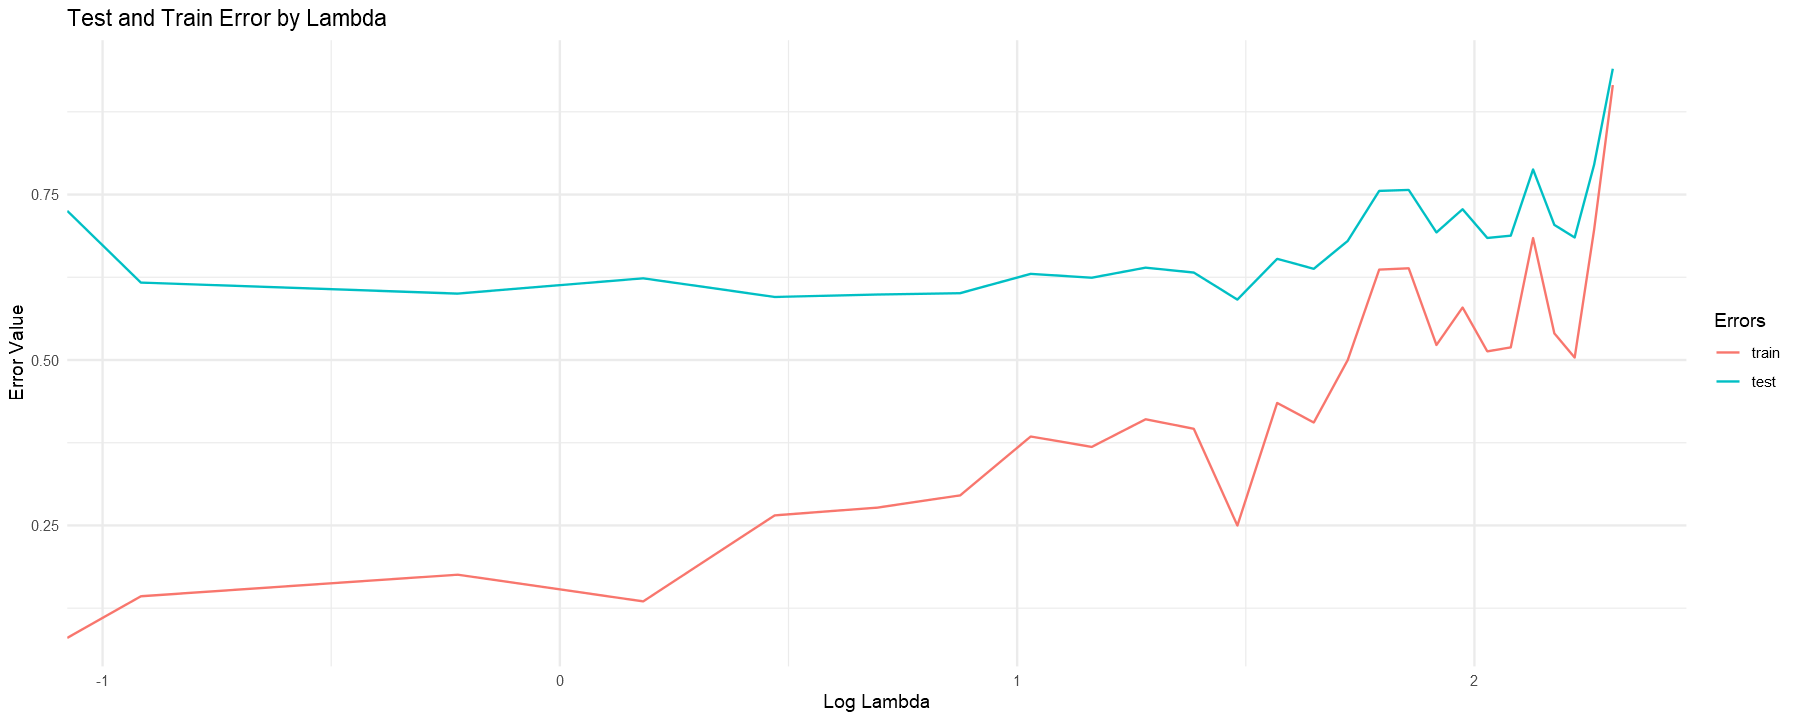

In [14]:
# adjusting plot size
options(repr.plot.width = 15, repr.plot.height = 6)
# plotting
ggplot(data=error.m, aes(x=log(L), y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error by Lambda') + xlab("Log Lambda") + ylab("Error Value")+
    scale_color_discrete(guide = guide_legend(title = 'Errors')) + theme_minimal()


    C. Based on your plot in the previous part (Part b), what’s the best value for lambda? Discuss lambda, model         
    complexity, and error rates, corresponding to underfitting and overfitting, by observing your plot. (Include all your answers in your Jupyter Notebook file.)

**Regularization is a technique that aims to improve predictive models by penalizing complexity and therefore reduce overfitting. A model overfits when a function is too closely fit to a limited set of data points, but does not perform well on generalizations and therefore has a small predictive power. When choosing the best lambda, we are looking for the lambda that reduces the error value of the testing dataset. We will now perform some data manipulation to find the value of the optimal lambda.**

In [15]:
# Finding optimal K
error_matrix[which.min(error_matrix[, "test"]),]

L     train      test 
4.4000000 0.2498473 0.5912695

**We have identified that the best lambda to minimize the test error is equal to 4.4. However, it is woth mentioning similar results for the testing error through a big range of observations. We may see in the plot above the test error ranging from 0.6 to 0.7 throughout the big majority of lambdas, from `lambda = 0.4` to `lambda = 5.6`.**

In [16]:
train

,x1,x2,x3,x4
1,-1.726272,-0.7686694,-1.253692,-1.1134012
2,-1.718566,-0.8609384,-1.252529,-1.4567195
3,-1.710859,-0.8126050,-1.233924,-1.4247683
4,-1.703152,-0.7603718,-1.242529,-1.3533481
5,-1.695446,-0.7407895,-1.208574,-1.2311819
6,-1.687739,-0.6894690,-1.147409,-1.1948453
7,-1.680032,-0.7637738,-1.139036,-1.2054957
8,-1.672326,-0.7853060,-1.123687,-1.1716651
9,-1.664620,-0.7552273,-1.116477,-1.1378344
10,-1.656912,-0.8322703,-1.147874,-1.0676672
